In [1]:
import os
import re
import gzip
import lzma
import zipfile
import json
import pathlib
from itertools import chain

import base64
import inspect
import importlib

from natsort import natsorted

import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from scipy.stats import ttest_ind

from IPython.display import SVG, Image

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib import colormaps
from PyComplexHeatmap import *
from adjustText import adjust_text

Read modeling results and data point counts.

In [2]:
data = pd.read_csv('../analysis/modelling/all_modelling_results.tsv.xz', sep='\t')
counts = pd.read_csv('../analysis/modelling/all_modelling_counts.tsv.xz', sep='\t')

Determine counts.

In [3]:
all_data = data.merge(counts, on='accession')

In [4]:
all_data['datapoints_mutant_percentage'] = all_data.num_datapoints_mutants / all_data.num_datapoints_total * 100
all_data['balance_coeff'] = (2 * (0.5 - ((50 - all_data.datapoints_mutant_percentage) / 100).abs()))

In [5]:
total_asc_order = (all_data[(all_data.subset == 'complete') & (all_data.modeltype == 'PCM') &
                        (all_data.crossval == 'random') & (all_data.folds == 'Mean') &
                        (all_data.contains_mutants == True)]
                   .query('num_datapoints_total > 100')
                   .sort_values(['num_datapoints_total', 'num_datapoints_mutants'], ascending=False)
                   )
top20_most_order = total_asc_order.accession.iloc[:20]
bottom20_most_order = total_asc_order.accession.iloc[-20:]

In [6]:
mutant_asc_order = (all_data[(all_data.subset == 'complete') & (all_data.modeltype == 'PCM') &
                             (all_data.crossval == 'random') & (all_data.folds == 'Mean') &
                             (all_data.contains_mutants == True)]
                    .query('num_datapoints_mutants > 100')
                    .sort_values(['num_datapoints_total', 'num_datapoints_mutants'], ascending=False)
                   )
top20_mutant_order = total_asc_order.accession.iloc[:20]
bottom20_mutant_order = total_asc_order.accession.iloc[-20:]

In [7]:
balance_asc_order = (all_data[(all_data.subset == 'complete') & (all_data.modeltype == 'PCM') &
                              (all_data.crossval == 'random') & (all_data.folds == 'Mean') &
                              (all_data.contains_mutants == True)]
                     .query('num_datapoints_total > 100')
                     .sort_values('balance_coeff', ascending=False)
                     )
top20_balanced_order = balance_asc_order.accession.iloc[:20]
bottom20_balanced_order = balance_asc_order.accession.iloc[-20:]

In [8]:
all_data

,folds,number,R2,MSE,RMSE,MSLE,RMSLE,MAE,Explained Variance,Max Error,...,subset,contains_mutants,modeltype,crossval,path,num_datapoints_total,num_datapoints_WT,num_datapoints_mutants,datapoints_mutant_percentage,balance_coeff
0,Fold 1,4.0,-18.963951,1.915666,1.384076,0.025973,0.161162,1.364290,0.433292,1.729147,...,common,True,PCM,per mutant,..\data\modelling\pcm_common_subset_mutantspli...,261.0,245.0,16.0,6.130268,0.122605
1,Fold 2,4.0,-38.603712,0.485145,0.696524,0.008415,0.091734,0.677614,-1.121192,0.947373,...,common,True,PCM,per mutant,..\data\modelling\pcm_common_subset_mutantspli...,261.0,245.0,16.0,6.130268,0.122605
2,Fold 3,4.0,-16.444156,0.485275,0.696617,0.008416,0.091740,0.677479,0.054686,0.949180,...,common,True,PCM,per mutant,..\data\modelling\pcm_common_subset_mutantspli...,261.0,245.0,16.0,6.130268,0.122605
3,Fold 4,4.0,-36.660599,0.646585,0.804105,0.009831,0.099151,0.795803,0.226351,0.983381,...,common,True,PCM,per mutant,..\data\modelling\pcm_common_subset_mutantspli...,261.0,245.0,16.0,6.130268,0.122605
4,Fold 5,4.0,-704.363244,5.515059,2.348416,0.105129,0.324236,2.345309,-0.865143,2.526364,...,common,True,PCM,per mutant,..\data\modelling\pcm_common_subset_mutantspli...,261.0,245.0,16.0,6.130268,0.122605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21555,Fold 3,673.0,0.381401,0.558842,0.747557,0.009605,0.098005,0.515271,0.381941,6.858958,...,complete,True,QSAR,random,..\data\modelling\qsar_randomsplit_Q99705.tsv,3365.0,3358.0,7.0,0.208024,0.004160
21556,Fold 4,673.0,0.526424,0.472153,0.687134,0.007793,0.088277,0.519613,0.526487,2.705204,...,complete,True,QSAR,random,..\data\modelling\qsar_randomsplit_Q99705.tsv,3365.0,3358.0,7.0,0.208024,0.004160
21557,Fold 5,673.0,0.470196,0.511106,0.714917,0.008435,0.091843,0.539227,0.471337,3.030335,...,complete,True,QSAR,random,..\data\modelling\qsar_randomsplit_Q99705.tsv,3365.0,3358.0,7.0,0.208024,0.004160
21558,Mean,673.0,0.478716,0.513423,0.716199,0.008642,0.092894,0.527602,0.480161,3.847433,...,complete,True,QSAR,random,..\data\modelling\qsar_randomsplit_Q99705.tsv,3365.0,3358.0,7.0,0.208024,0.004160


In [9]:
scatter_data = (all_data[all_data.folds == 'Mean']
                [['accession', 'Pearson r', 'subset', 'contains_mutants', 'crossval', 'modeltype', 'num_datapoints_total', 'num_datapoints_mutants', 'datapoints_mutant_percentage', 'balance_coeff']]
                )
scatter_data = scatter_data.pivot(columns=['modeltype', 'subset', 'contains_mutants', 'crossval'], values=['Pearson r'], index=['accession', 'num_datapoints_total', 'num_datapoints_mutants', 'datapoints_mutant_percentage', 'balance_coeff']).reset_index()
scatter_data.columns = ['_'.join(filter(lambda x: x != '', map(str, indices))).replace(' ', '_') for indices in scatter_data.columns.values]

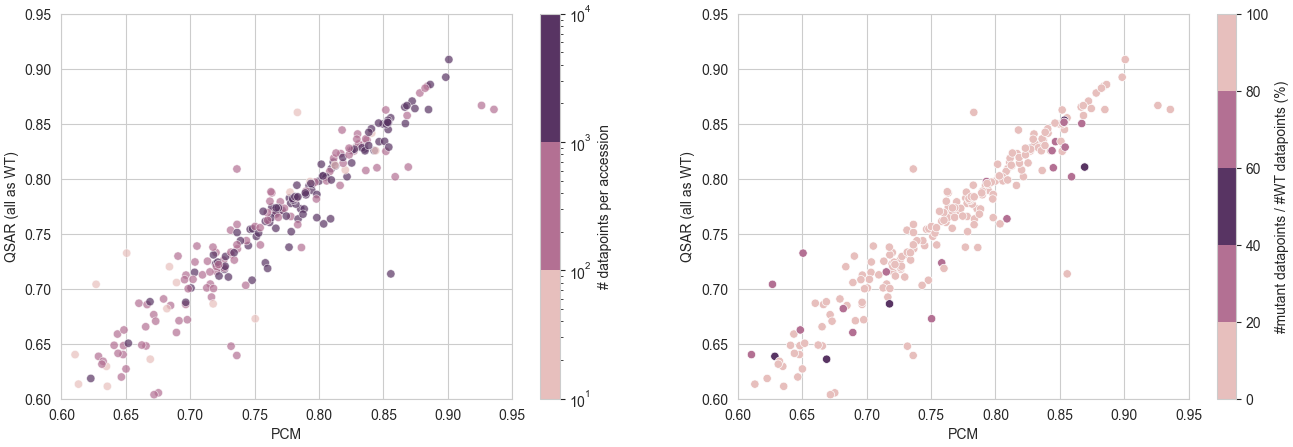

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))
ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_True_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=1,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (all as WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))

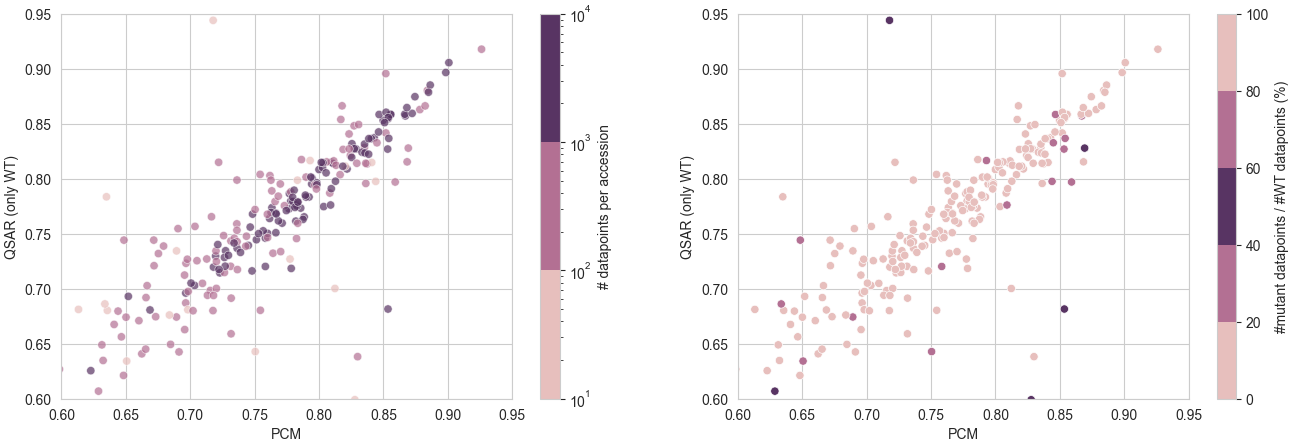

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))
ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=1,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))

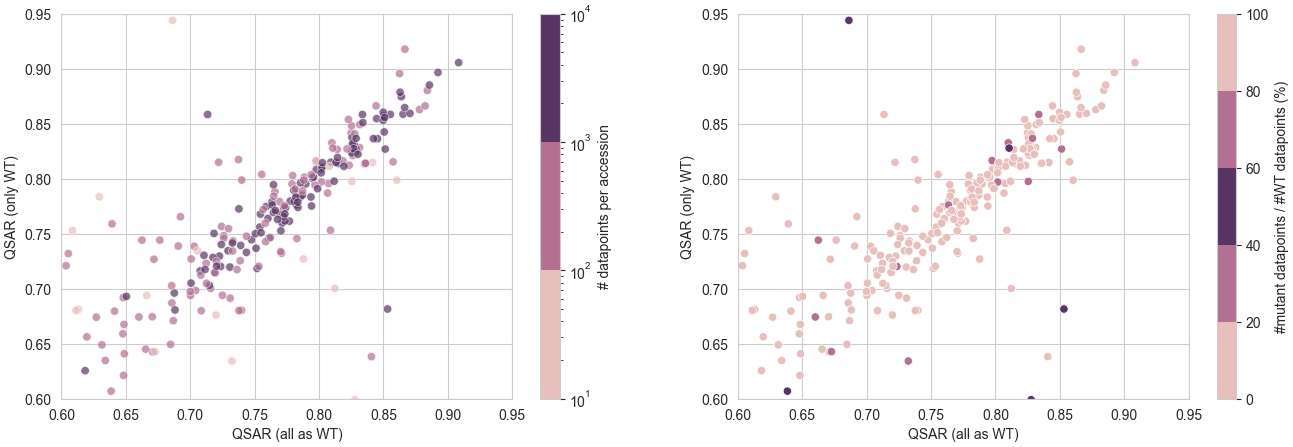

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))
ax1 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=1,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='QSAR (all as WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))

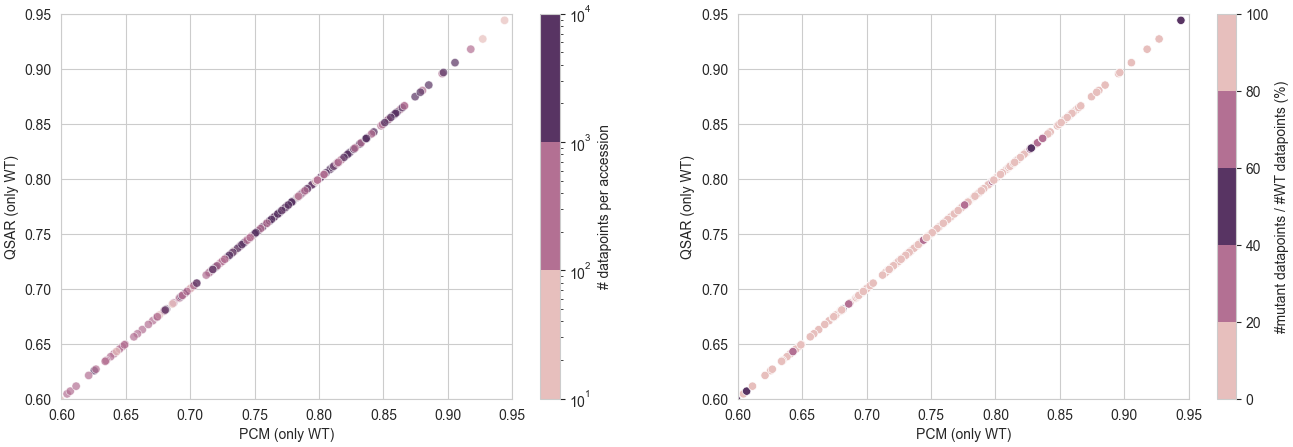

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))
ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_False_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_False_random',
                      y='Pearson_r_QSAR_complete_False_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=1,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM (only WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))
_ = ax2.set(xlabel='PCM (only WT)', ylabel='QSAR (only WT)',
            xlim=(0.6, 0.95), ylim=(0.6, 0.95))

Since the data contains only WT, adding protein descriptors does not confer PCM with any advantage over QSAR modelling. 

## Common subsets

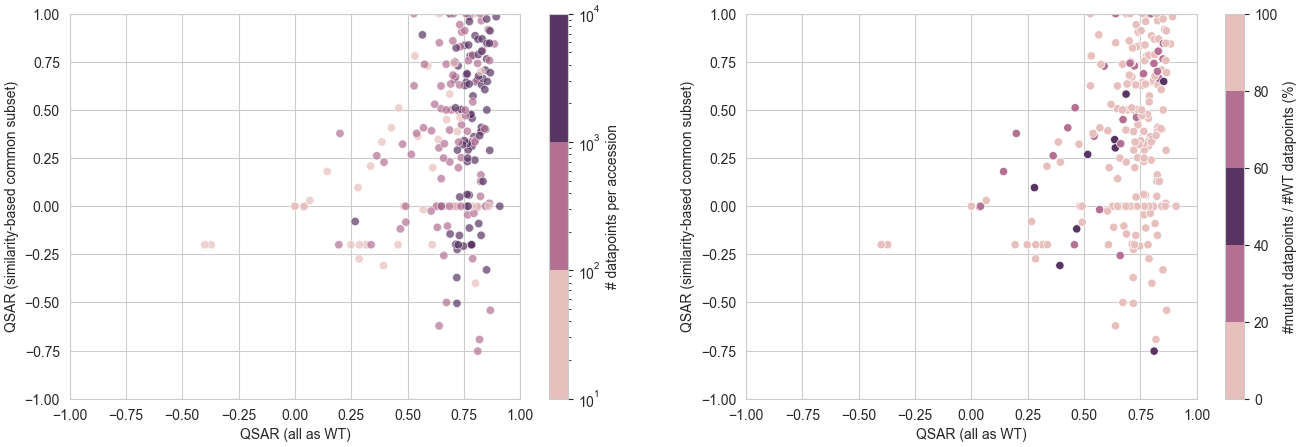

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))
ax1 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_QSAR_complete_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=1,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax2.set(xlabel='QSAR (all as WT)', ylabel='QSAR (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

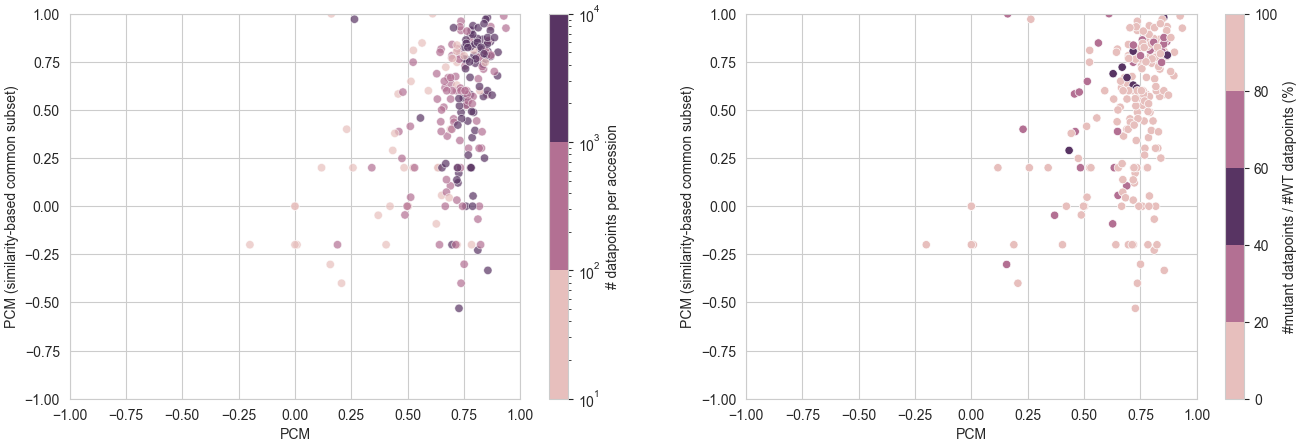

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))
ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_random',
                      y='Pearson_r_PCM_common_True_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=1,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax2.set(xlabel='PCM', ylabel='PCM (similarity-based common subset)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

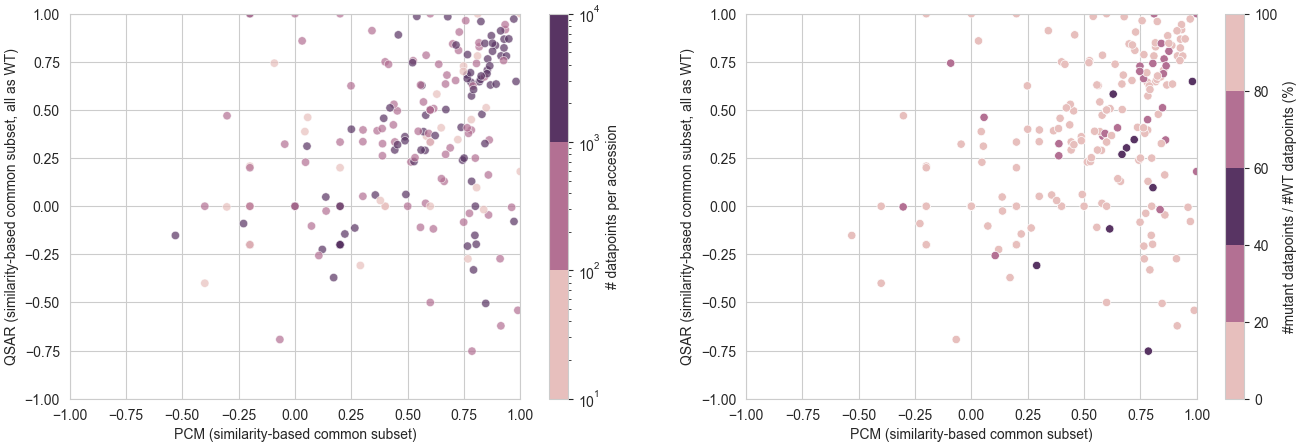

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))
ax1 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_common_True_random',
                      y='Pearson_r_QSAR_common_True_random',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=1,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax2.set(xlabel='PCM (similarity-based common subset)', ylabel='QSAR (similarity-based common subset, all as WT)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

## LOMO cross-validation

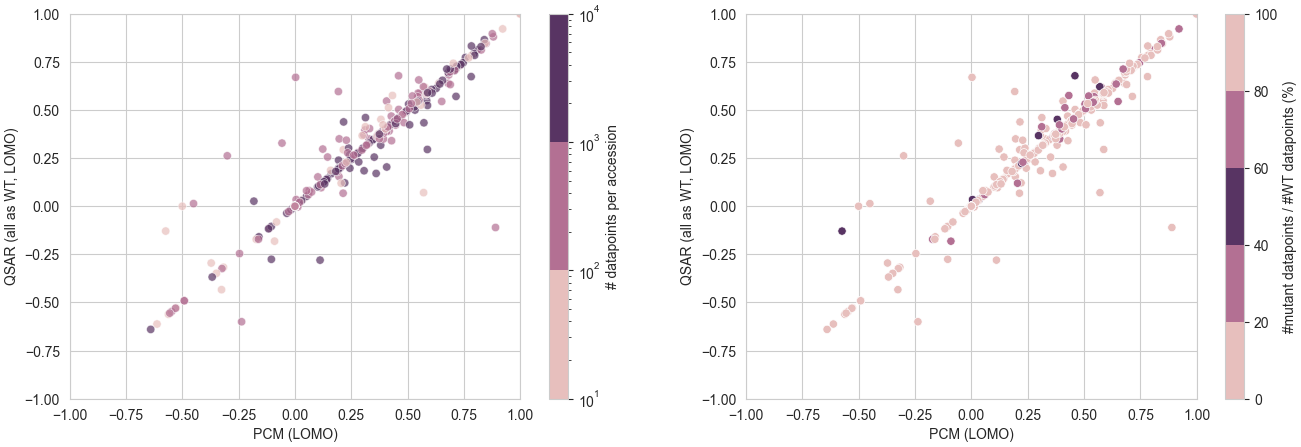

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 5)) 
palette = matplotlib.colors.ListedColormap(sns.cubehelix_palette(as_cmap=True).colors[20::96])
div_palette = matplotlib.colors.ListedColormap(np.vstack((palette.colors, palette.colors[1::-1])))
ax1 = sns.scatterplot(x='Pearson_r_PCM_complete_True_per_mutant',
                      y='Pearson_r_QSAR_complete_True_per_mutant',
                      hue='num_datapoints_total',
                      data=scatter_data, 
                      alpha=0.7,
                      hue_norm=matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True),
                      palette=palette,
                      ax=axes[0])
norm1 = matplotlib.colors.LogNorm(10, 10 ** int(np.log10(scatter_data.num_datapoints_total.max())), clip=True)
sm1 = plt.cm.ScalarMappable(cmap=palette,
                            norm=norm1)
ax1.get_legend().remove()
ax1.figure.colorbar(sm1, ax=ax1, label='# datapoints per accession')


ax2 = sns.scatterplot(x='Pearson_r_PCM_complete_True_per_mutant',
                      y='Pearson_r_QSAR_complete_True_per_mutant',
                      hue='datapoints_mutant_percentage',
                      data=scatter_data,
                      alpha=1,
                      palette=div_palette,
                      ax=axes[1])
norm2 = plt.Normalize(0, 100)
sm2 = plt.cm.ScalarMappable(cmap=div_palette,
                            norm=norm2)
ax2.get_legend().remove()
ax2.figure.colorbar(sm2, ax=ax2, label='#mutant datapoints / #WT datapoints (%)')


_ = ax1.set(xlabel='PCM (LOMO)', ylabel='QSAR (all as WT, LOMO)',
            xlim=(-1, 1), ylim=(-1, 1)
            )
_ = ax2.set(xlabel='PCM (LOMO)', ylabel='QSAR (all as WT, LOMO)',
            xlim=(-1, 1), ylim=(-1, 1)
            )

## Interesting targets

## Protein families

## Differences in bioactivity